**Problem statement**: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

The dataset consists of 2357 images of malignant and benign oncological diseases, which were formed from the **International Skin Imaging Collaboration (ISIC)**. All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant.

In this assignment, we will build a **multiclass classification model using a custom convolutional neural network in TensorFlow**.

##### Data Summary:

The data set contains the following diseases:

- Actinic keratosis
- Basal cell carcinoma
- Dermatofibroma
- Melanoma
- Nevus
- Pigmented benign keratosis
- Seborrheic keratosis
- Squamous cell carcinoma
- Vascular lesion


### Importing all the important libraries

In [2]:
# importing all respective libraries
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
%matplotlib inline

### Importing Skin Cancer Data
- Upload the Skin Cancer Data to Google Drive and then utilize google.colab to connect the drive.

In [1]:
# un-comment when running in google colab
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [77]:
data_dir_train = pathlib.Path("/content/drive/MyDrive/upgrad/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/drive/MyDrive/upgrad/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2249
118


- This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

- Out of total 2357 images, 2239 are train images and 118 are test images

### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  directory=data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2249 files belonging to 9 classes.
Using 1800 files for training.


In [8]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
  directory=data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2249 files belonging to 9 classes.
Using 449 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
- Visualizing few of images

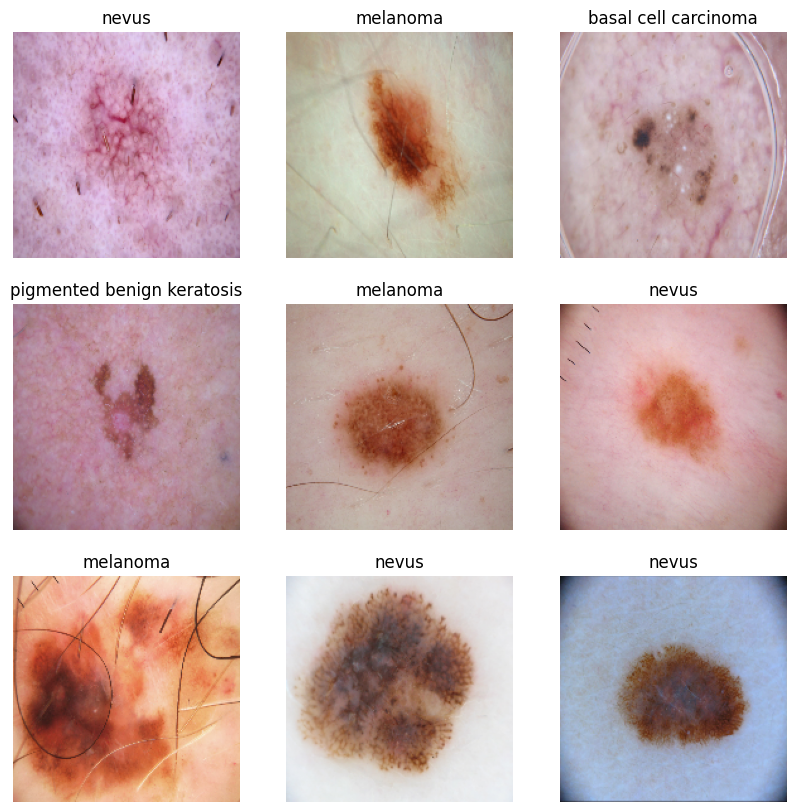

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

- Viewing shape of tensor of train_ds and val_ds

In [11]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [14]:
img_rows, img_cols = 180, 180
input_shape = (img_rows, img_cols, 3)
num_classes = len(class_names)

model = Sequential()
model.add(layers.Rescaling(1./255, input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3),padding = 'same',activation= 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3, 3),padding = 'same',activation ='relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3, 3),padding = 'same',activation ='relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3, 3),padding = 'same',activation ='relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Conv2D(16, kernel_size=(7, 7),padding = 'same',activation= 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, kernel_size=(11,11),padding = 'same',activation ='relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(256, kernel_size=(3, 3),padding = 'same',activation ='relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(9,activation='softmax'))


In [15]:
# print model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 90, 90, 32)        0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 90, 90, 32)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 45, 45, 64)        0         
 g2D)                                                 

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [16]:
### choose an appropirate optimiser and loss function
opt=tf.keras.optimizers.Adam()
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

### Train the model

In [17]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
57/57 [==============================] - 433s 2s/step - loss: 2.0603 - accuracy: 0.1956 - val_loss: 2.0875 - val_accuracy: 0.1871
Epoch 2/20
57/57 [==============================] - 3s 56ms/step - loss: 2.0269 - accuracy: 0.2044 - val_loss: 2.0255 - val_accuracy: 0.1960
Epoch 3/20
57/57 [==============================] - 3s 55ms/step - loss: 2.0016 - accuracy: 0.2083 - val_loss: 1.9713 - val_accuracy: 0.2851
Epoch 4/20
57/57 [==============================] - 3s 56ms/step - loss: 1.8698 - accuracy: 0.3000 - val_loss: 1.8263 - val_accuracy: 0.3252
Epoch 5/20
57/57 [==============================] - 3s 54ms/step - loss: 1.7708 - accuracy: 0.3306 - val_loss: 1.8652 - val_accuracy: 0.2606
Epoch 6/20
57/57 [==============================] - 3s 54ms/step - loss: 1.6875 - accuracy: 0.3717 - val_loss: 1.6419 - val_accuracy: 0.3942
Epoch 7/20
57/57 [==============================] - 3s 58ms/step - loss: 1.6910 - accuracy: 0.3606 - val_loss: 1.7366 - val_accuracy: 0.3185
Epoch 8/20
57

### Visualizing training results

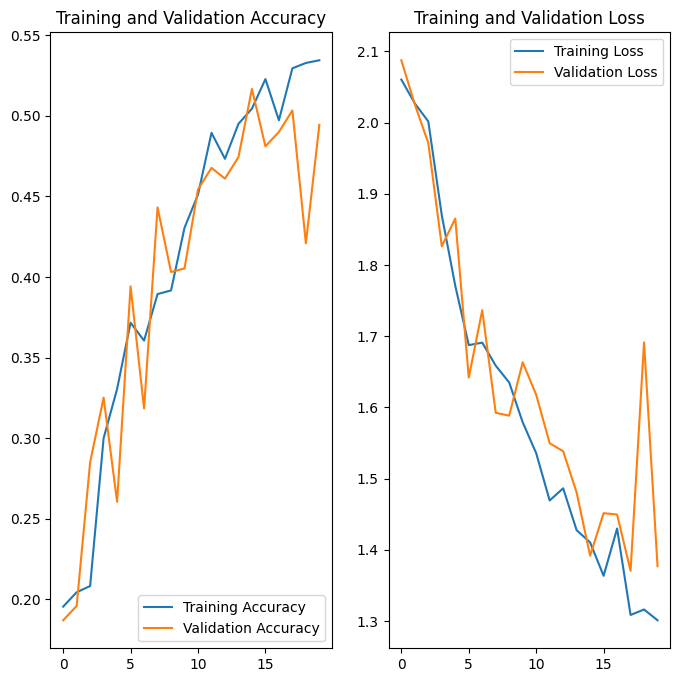

In [18]:
# Visualizing training results by plotting
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [19]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

15/15 [==============================] - 0s 10ms/step - loss: 1.3771 - accuracy: 0.4944
Accuracy:  0.554444432258606
Validation Accuracy:  0.4944320619106293
Loss:  1.2586181163787842
Validation Loss 1.3770872354507446


#### Write your findings after the model fit, see if there is an evidence of model overfit or underfit

##### Findings
- The training accuracy is more than validation accuracy.
- The model is overfitting.
- The model accuracy is low.

In [28]:
# choosing an appropriate data augumentation strategy.
data_augmentation = tf.keras.Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical", input_shape= input_shape),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.1),
  ]
)

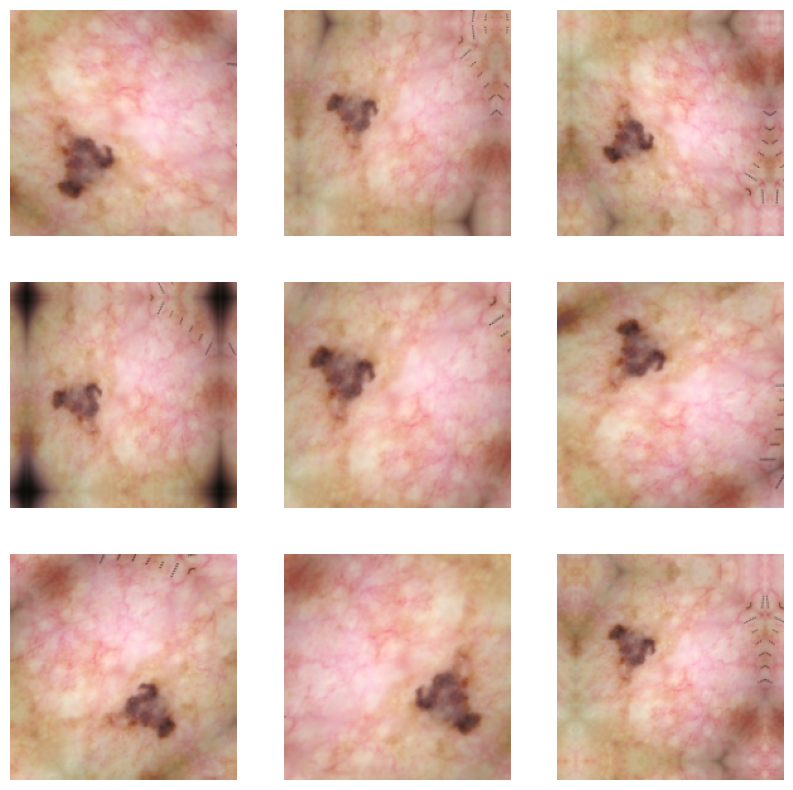

In [29]:
# Visualize how  augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Create, compile and train the model

In [30]:
model = Sequential()

model.add(layers.Rescaling(1./255, input_shape=input_shape))
model.add(data_augmentation)
model.add(Conv2D(32, kernel_size=(3, 3),padding = 'same',activation= 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3, 3),padding = 'same',activation ='relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3, 3),padding = 'same',activation ='relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3, 3),padding = 'same',activation ='relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Conv2D(16, kernel_size=(7, 7),padding = 'same',activation= 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, kernel_size=(11, 11),padding = 'same',activation ='relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(256, kernel_size=(3, 3),padding = 'same',activation ='relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(9,activation='softmax'))

### Compiling the model

In [31]:
# Choosing an appropirate optimiser and loss function
opt=tf.keras.optimizers.Adam()
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [32]:
# view the summary of all layers
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_4 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_21 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 90, 90, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_18 (Dropout)        (None, 90, 90, 32)        0         
                                                                 
 conv2d_22 (Conv2D)          (None, 90, 90, 64)        18496     
                                                      

### Training the model

In [33]:
# train the model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
57/57 [==============================] - 8s 65ms/step - loss: 2.0657 - accuracy: 0.1828 - val_loss: 2.0952 - val_accuracy: 0.1960
Epoch 2/20
57/57 [==============================] - 3s 57ms/step - loss: 2.0301 - accuracy: 0.1906 - val_loss: 2.0220 - val_accuracy: 0.1871
Epoch 3/20
57/57 [==============================] - 3s 58ms/step - loss: 1.9802 - accuracy: 0.2494 - val_loss: 1.8567 - val_accuracy: 0.2739
Epoch 4/20
57/57 [==============================] - 4s 62ms/step - loss: 1.8249 - accuracy: 0.3144 - val_loss: 1.7373 - val_accuracy: 0.2984
Epoch 5/20
57/57 [==============================] - 3s 57ms/step - loss: 1.7215 - accuracy: 0.3444 - val_loss: 1.6739 - val_accuracy: 0.3875
Epoch 6/20
57/57 [==============================] - 3s 55ms/step - loss: 1.6727 - accuracy: 0.3844 - val_loss: 1.7636 - val_accuracy: 0.3408
Epoch 7/20
57/57 [==============================] - 3s 60ms/step - loss: 1.6405 - accuracy: 0.3928 - val_loss: 1.5602 - val_accuracy: 0.4432
Epoch 8/20
57

### Visualizing the results

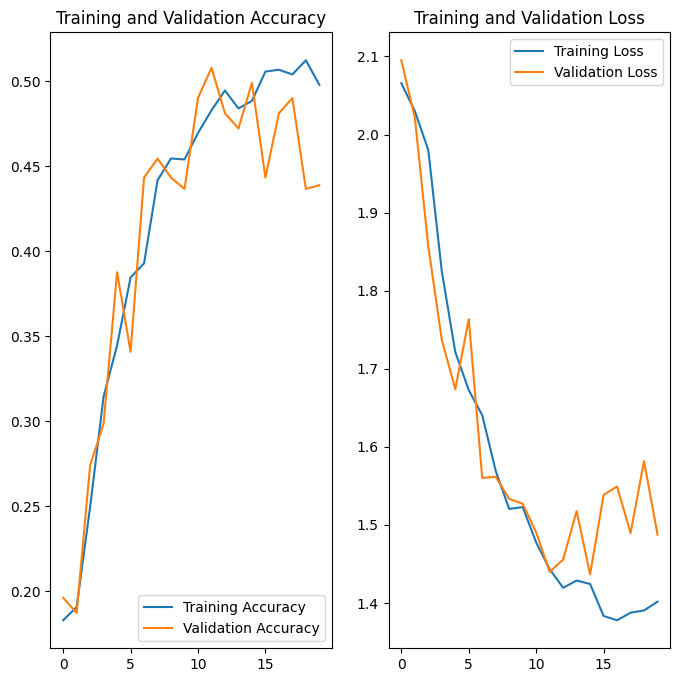

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [35]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

15/15 [==============================] - 0s 10ms/step - loss: 1.4876 - accuracy: 0.4388
Accuracy:  0.46888887882232666
Validation Accuracy:  0.43875277042388916
Loss:  1.442497968673706
Validation Loss 1.487635612487793


#### Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### Observations
- The similarity between the training accuracy and validation accuracy indicates a good fit.
- The overall accuracy remains quite low.
- It is evident that the model needs additional epochs to be trained properly
- The class imbalance need to be addressed.

#### Find the distribution of classes in the training dataset.
##### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [36]:
# find number of images in each classes
data = []
for i in range(len(class_names)):
  name = class_names[i]
  number = len(list(data_dir_train.glob(f'{class_names[i]}/*.jpg')))
  data.append([name, number])
df = pd.DataFrame(data, columns=['class', 'number'])
df

,class,number
0,actinic keratosis,114
1,basal cell carcinoma,376
2,dermatofibroma,95
3,melanoma,438
4,nevus,367
5,pigmented benign keratosis,462
6,seborrheic keratosis,77
7,squamous cell carcinoma,181
8,vascular lesion,139


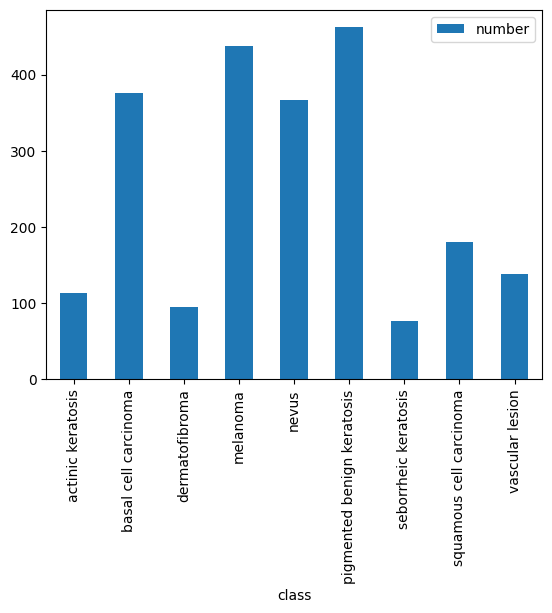

In [37]:
# bar plot for number of images in each class
df.plot.bar(x='class',y='number',rot=90)
plt.show()

#### Write your findings here:
##### Which class has the least number of samples?
 - Ans - "seborrheic keratosis" has least number of samples. It only contains 77 images.

##### Which classes dominate the data in terms proportionate number of samples?
  - Ans - "pigmented benign keratosis" contains most number of sample. It contains 462 samples.

#### Rectify the class imbalance
##### **Context:** We can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [38]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [61]:
# path google drive training dataset
path_to_training_dataset="/content/drive/MyDrive/upgrad/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"

import Augmentor
for i in class_names:
    # un-comment below line if running in kaggle
    # p = Augmentor.Pipeline(path_to_training_dataset + i, output_directory='/kaggle/working/'+i+'/output/')

    # path google drive training dataset for augmenting
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/upgrad/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B4E190AE080>: 100%|██████████| 500/500 [00:19<00:00, 26.19 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/upgrad/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B4E190E6200>: 100%|██████████| 500/500 [00:19<00:00, 25.63 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/upgrad/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B4E16242FB0>: 100%|██████████| 500/500 [00:20<00:00, 24.86 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/upgrad/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7B4E16241840>: 100%|██████████| 500/500 [01:18<00:00,  6.34 Samples/s]


Initialised with 367 image(s) found.
Output directory set to /content/drive/MyDrive/upgrad/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1504x1129 at 0x7B4E3B97D540>: 100%|██████████| 500/500 [01:17<00:00,  6.43 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/upgrad/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B4E16681780>: 100%|██████████| 500/500 [00:18<00:00, 27.51 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/upgrad/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7B4E16484130>: 100%|██████████| 500/500 [00:40<00:00, 12.43 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/upgrad/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B4E16681780>: 100%|██████████| 500/500 [00:18<00:00, 27.77 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/upgrad/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7B4E161BD630>: 100%|██████████| 500/500 [00:18<00:00, 26.48 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [62]:
out_dir = pathlib.Path("/content/drive/MyDrive/upgrad/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
image_count_train = len(list(out_dir.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [63]:
from glob import glob
path_list = [x for x in glob(os.path.join(out_dir, '*','output', '*.jpg'))]
path_list

['/content/drive/MyDrive/upgrad/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000356.jpg_7e1ffc89-29ab-486f-b432-a45a2b54227b.jpg',
 '/content/drive/MyDrive/upgrad/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0025780.jpg_d00e3f8d-0b3c-428d-a7ca-4e48d5075600.jpg',
 '/content/drive/MyDrive/upgrad/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0028063.jpg_4c68757b-59d3-4903-aed6-39a76b2ab2d1.jpg',
 '/content/drive/MyDrive/upgrad/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0025368.jpg_8608055e-8943-491c-bd12-ebae8ea4767d.jpg',
 '/content/drive/MyDrive/upgrad/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000333.jpg_f7d7857b-b119-427b-9a56-f4ace4b6ac47.jpg',
 '/content/drive/MyDrive/upgrad/Skin cancer ISIC The Interna

In [64]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(out_dir, '*','output', '*.jpg'))]
lesion_list_new

['nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',


In [65]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [66]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
df2

,Path,Label
0,/content/drive/MyDrive/upgrad/Skin cancer ISIC...,nevus
1,/content/drive/MyDrive/upgrad/Skin cancer ISIC...,nevus
2,/content/drive/MyDrive/upgrad/Skin cancer ISIC...,nevus
3,/content/drive/MyDrive/upgrad/Skin cancer ISIC...,nevus
4,/content/drive/MyDrive/upgrad/Skin cancer ISIC...,nevus
...,...,...
4495,/content/drive/MyDrive/upgrad/Skin cancer ISIC...,squamous cell carcinoma
4496,/content/drive/MyDrive/upgrad/Skin cancer ISIC...,squamous cell carcinoma
4497,/content/drive/MyDrive/upgrad/Skin cancer ISIC...,squamous cell carcinoma
4498,/content/drive/MyDrive/upgrad/Skin cancer ISIC...,squamous cell carcinoma


In [67]:
df2['Label'].value_counts()

Label
nevus                         500
melanoma                      500
actinic keratosis             500
basal cell carcinoma          500
vascular lesion               500
seborrheic keratosis          500
pigmented benign keratosis    500
dermatofibroma                500
squamous cell carcinoma       500
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [68]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [80]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6749 files belonging to 9 classes.
Using 5400 files for training.


#### Create a validation dataset

In [81]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6749 files belonging to 9 classes.
Using 1349 files for validation.


#### Create your model (make sure to include normalization)

In [82]:
model = Sequential()
model.add(layers.Rescaling(1./255,input_shape=(180,180,3)))

model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2)))

model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2)))

model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2)))

model.add(layers.Conv2D(256,kernel_size=(11,11),activation='relu'))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.5))

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(128,activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(len(class_names),activation='softmax'))

#### Compile your model (Choose optimizer and loss function appropriately)

In [83]:
opt=tf.keras.optimizers.Adam()
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [84]:
# View the summary of all layers
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_32 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 batch_normalization_4 (Bat  (None, 178, 178, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_32 (MaxPooli  (None, 89, 89, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_33 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 batch_normalization_5 (Bat  (None, 87, 87, 64)       

#### Train the model

In [85]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 54s 266ms/step - loss: 2.2057 - accuracy: 0.2674 - val_loss: 2.4081 - val_accuracy: 0.0897
Epoch 2/30
169/169 [==============================] - 43s 245ms/step - loss: 1.7527 - accuracy: 0.3463 - val_loss: 2.4513 - val_accuracy: 0.1453
Epoch 3/30
169/169 [==============================] - 43s 248ms/step - loss: 1.6447 - accuracy: 0.3757 - val_loss: 1.5763 - val_accuracy: 0.3966
Epoch 4/30
169/169 [==============================] - 43s 246ms/step - loss: 1.5304 - accuracy: 0.4083 - val_loss: 3.2529 - val_accuracy: 0.2513
Epoch 5/30
169/169 [==============================] - 46s 263ms/step - loss: 1.4761 - accuracy: 0.4315 - val_loss: 1.6561 - val_accuracy: 0.3529
Epoch 6/30
169/169 [==============================] - 43s 247ms/step - loss: 1.4081 - accuracy: 0.4613 - val_loss: 1.5970 - val_accuracy: 0.3662
Epoch 7/30
169/169 [==============================] - 43s 245ms/step - loss: 1.3917 - accuracy: 0.4631 - val_loss: 6.0675 - val_ac

#### Visualize the model results

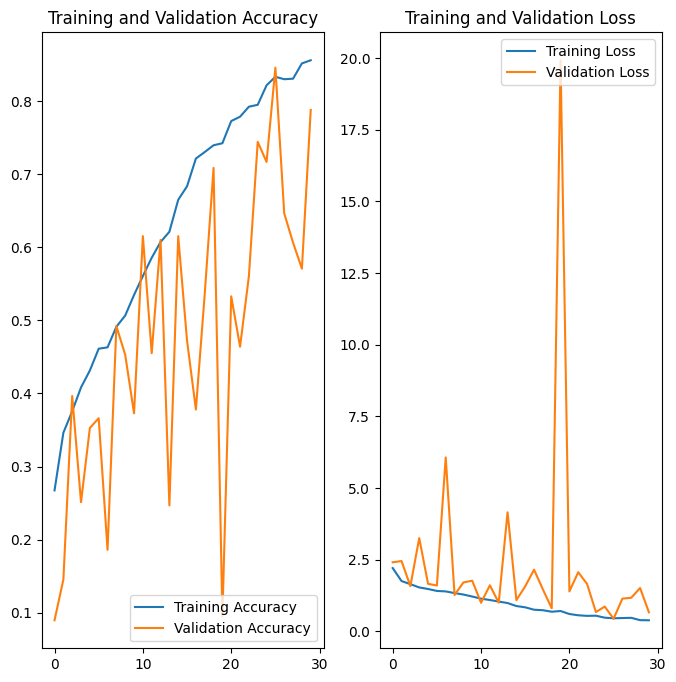

In [86]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [87]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

43/43 [==============================] - 10s 197ms/step - loss: 0.6623 - accuracy: 0.7880
Accuracy:  0.8412963151931763
Validation Accuracy:  0.7879911065101624
Loss:  0.4544583261013031
Validation Loss 0.6623135805130005


#### Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

##### Findings :
- The training accuracy closely matches the validation accuracy, indicating a good fit.
- The training loss and validation loss show little variance, suggesting a well-matched model.
- The Validation accuracy is 0.79. The model is able to classify the images with 75% accuracy.

### Test the model

1/1 [==============================] - 1s 603ms/step
Actual Class: basal cell carcinoma
Predictive Class: basal cell carcinoma


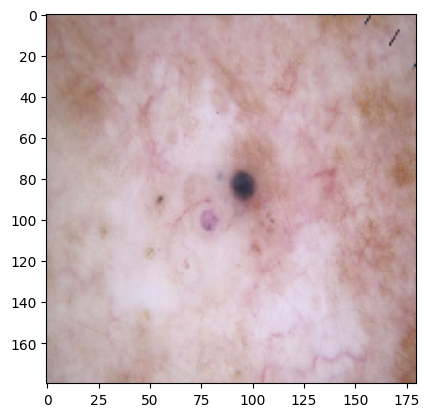

In [88]:
from glob import glob
from tensorflow.keras.preprocessing.image import load_img, img_to_array
Test_image_path = os.path.join(data_dir_test, class_names[1], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print(f"Actual Class: {class_names[1]}" + '\n' + "Predictive Class: " + pred_class)